##### __Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.patches as mpatches  # create custom plot legends
import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from matplotlib.lines import Line2D  # matplotlib custom lines
from scipy import stats  # statistical tests
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

##### __Options and constants__

In [2]:
warnings.filterwarnings("ignore")

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""

CHECK = "insidecar_%"

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.2f}".format

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 16


##### __Helper functions__

In [3]:
def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)


def bartlett_test(df):
    # check if the variance is homogeneous
    # collect conditions
    conds = df.condition.unique()

    print(f"{CHECK} variance per condition:")
    cond_var = pd.DataFrame(columns=conds)
    for cond in conds:
        cond_var[cond] = df[df.condition == cond].var()
    display(cond_var.loc[CHECK])

    # check for variance homogeneity using Bartlett's test:
    bartlett_pv = stats.bartlett(
        df[df.condition == "AVAS"][CHECK],
        df[df.condition == "TaxiDriver"][CHECK],
        df[df.condition == "RadioTalk"][CHECK],
    )[1]

    print(f"Bartlett's p-value is {bartlett_pv:.12f}")
    print(f"So, is the variance ({CHECK}) between groups homogeneous (p > 0.05)?")
    res = bartlett_pv > 0.05
    print(res)
    return res


def t_test(df, eq_var):
    # conditions
    conds = df.condition.unique()
    # combinations of conditions to test
    combs = list(itertools.combinations(conds, 2))
    # tranlate combinations (tuples) to column names
    combs_str = [f"{c[0]} vs {c[1]}" for c in combs]
    # df result to fill out
    res = pd.DataFrame(columns=combs_str)

    # iterate over combinations to compute t-test
    for i, c in enumerate(combs_str):
        # select groups to test
        first_grp = df[df.condition == combs[i][0]][CHECK]
        second_grp = df[df.condition == combs[i][1]][CHECK]
        # p-value using Student's (equal var) or Welch's t-test (diff var)
        values = stats.ttest_ind(first_grp, second_grp, equal_var=eq_var)
        res.loc["p-value", c] = values[1]
        check = "✔️" if values[1] < 0.05 else "❌"
        res.loc["significance", c] = check

    display(res)

In [4]:
# store and preview the enhanced participants list
parts = pd.read_csv("./participants_clean.csv", index_col=0)
parts

,date,expo,side,condition,nulls_%,sky_%,insidecar_%,questionnaire
id,,,,,,,,
4f583872ffed48249874b00f3d389cfc,2019-05-14 13:21:00,MSW,right,TaxiDriver,1.61,13.74,2.36,No
33d68ad55ef544fab9fd08108e3913ca,2019-05-14 16:44:00,MSW,right,AVAS,0.04,0.67,25.42,No
8598a83e2af441b8bcd0ae5d84beb875,2019-05-14 16:51:00,MSW,right,RadioTalk,0.04,33.13,0.79,No
37d7e67934974217830bb429bba7fd76,2019-05-14 16:54:00,MSW,left,AVAS,0.82,18.61,2.85,No
42bac596059749b5b8e8e83ae61de9b4,2019-05-14 16:56:00,MSW,right,TaxiDriver,0.22,26.99,0.26,No
...,...,...,...,...,...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,2019-12-30 15:29:00,BMBF,right,AVAS,0.30,32.16,0.00,No
611d35a7c3e940cc82495e53c2a8532d,2020-01-03 16:12:00,BMBF,right,TaxiDriver,0.67,15.46,5.05,No
3b6fda285d9e412eb081986b2f22a2e3,2020-01-03 16:13:00,BMBF,left,AVAS,1.80,3.37,11.72,No


Gaussian fit of the distribution

mean: 9.971493912308741
std: 9.943396623347192


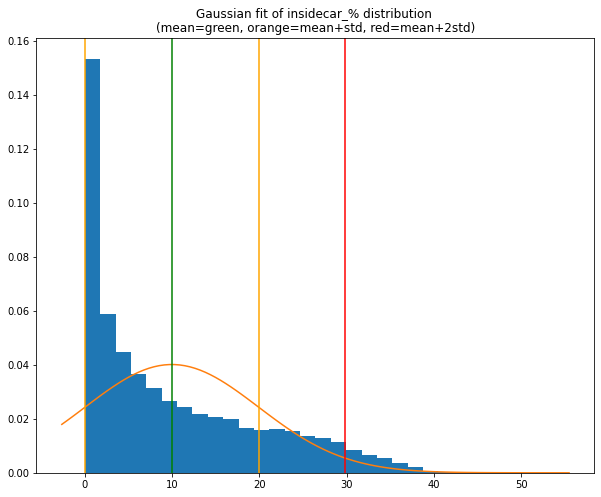

In [14]:
mean, std = stats.norm.fit(parts[CHECK])
print(f"mean: {mean}")
print(f"std: {std}")

plt.rcParams["figure.figsize"] = (10, 8)
plt.hist(parts[CHECK], bins=30, density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = stats.norm.pdf(x, mean, std)
plt.plot(x, y)
plt.axvline(mean, color="g")
plt.axvline(mean + std, color="orange")
plt.axvline(mean - std, color="orange")
plt.axvline(mean + std * 2, color="r")

plt.title(
    f"Gaussian fit of {CHECK} distribution \n(mean=green, orange=mean+std, red=mean+2std)"
)
plt.show()

How many participants are outliers (more than 2 std)?

In [6]:
total_parts = parts.index.size
total_out = parts[parts[CHECK] > mean + std * 2].index.size
perc_out = total_out * 100 / total_parts

soft_out = parts[parts[CHECK] > mean + std].index.size
perc_soft = soft_out * 100 / total_parts

print(
    f"From a total of {total_parts} (100%) participants (mean={mean:.2f}, std={std:.2f}):"
)
print(
    f"=> {total_out} ({perc_out:.2f}%) are clear outliers (> mean + 2 * std)"
)
print(f"=> {soft_out} ({perc_soft:.2f}%) are soft outliers (> mean + std)")

From a total of 24356 (100%) participants (mean=9.97, std=9.94):
=> 1217 (5.00%) are clear outliers (> mean + 2 * std)
=> 4634 (19.03%) are soft outliers (> mean + std)


How are the conditions distributed before and after removing the outliers?

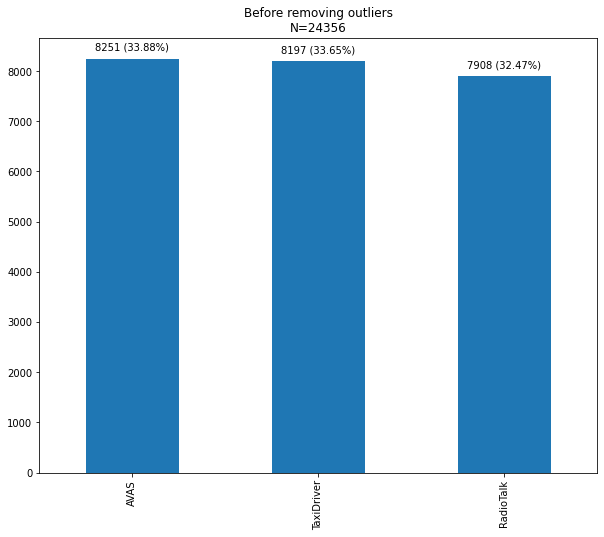

insidecar_% variance per condition:


TaxiDriver   102.35
AVAS          98.62
RadioTalk     95.52
Name: insidecar_%, dtype: float64

Bartlett's p-value is 0.008124490955
So, is the variance (insidecar_%) between groups homogeneous (p > 0.05)?
False

Is the difference between insidecar_% between conditions significant?


,TaxiDriver vs AVAS,TaxiDriver vs RadioTalk,AVAS vs RadioTalk
p-value,0.19573844894519298876,0.47173401427690653254,0.04213128761907263681
significance,❌,❌,✔️


In [7]:
sel = parts
N = sel.index.size
title = f"Before removing outliers\nN={parts.index.size}"
ax = sel["condition"].value_counts().plot(kind="bar", title=title)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    perc = height * 100 / N
    ax.annotate(
        f"{height} ({perc:.2f}%)",
        (x + width / 2, y + height * 1.02),
        ha="center",
    )
plt.show()

eq_var = bartlett_test(sel)

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.20f}".format
print()
print(f"Is the difference between {CHECK} between conditions significant?")
t_test(sel, eq_var)

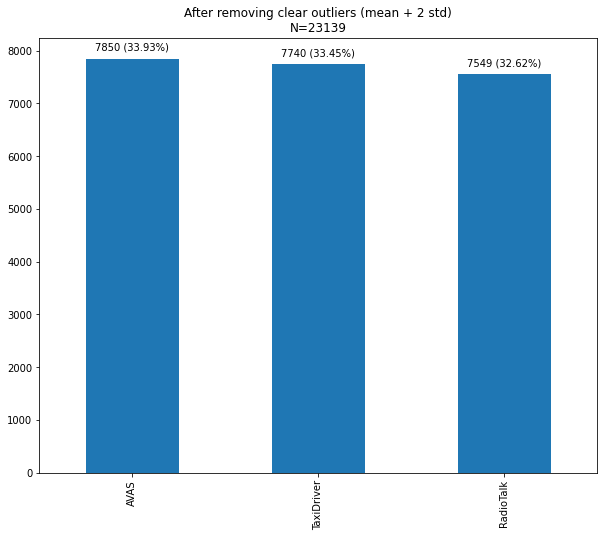

insidecar_% variance per condition:


TaxiDriver   73.58105837233144086440
AVAS         72.97630741474513627054
RadioTalk    71.83729822269697251613
Name: insidecar_%, dtype: float64

Bartlett's p-value is 0.568104031747
So, is the variance (insidecar_%) between groups homogeneous (p > 0.05)?
True

Is the difference between insidecar_% between conditions significant?


,TaxiDriver vs AVAS,TaxiDriver vs RadioTalk,AVAS vs RadioTalk
p-value,0.82525855415239501855,0.00648581695832526131,0.00309728984543430983
significance,❌,✔️,✔️


In [8]:
sel = parts[parts[CHECK] < mean + std * 2]
N = sel.index.size
title = f"After removing clear outliers (mean + 2 std)\nN={sel.index.size}"
ax = sel["condition"].value_counts().plot(kind="bar", title=title)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    perc = height * 100 / N
    ax.annotate(
        f"{height} ({perc:.2f}%)",
        (x + width / 2, y + height * 1.02),
        ha="center",
    )
plt.show()

eq_var = bartlett_test(sel)

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.20f}".format
print()
print(f"Is the difference between {CHECK} between conditions significant?")
t_test(sel, eq_var)

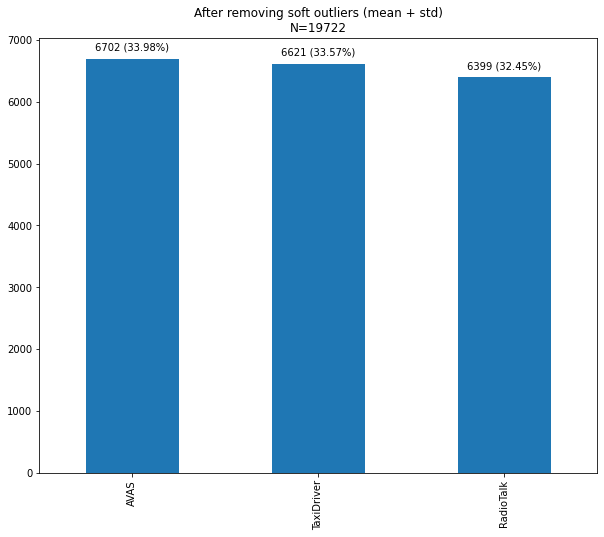

insidecar_% variance per condition:


TaxiDriver   33.48186095211582369302
RadioTalk    33.50042828736640387888
AVAS         33.03613461534713025003
Name: insidecar_%, dtype: float64

Bartlett's p-value is 0.813235199856
So, is the variance (insidecar_%) between groups homogeneous (p > 0.05)?
True

Is the difference between insidecar_% between conditions significant?


,TaxiDriver vs RadioTalk,TaxiDriver vs AVAS,RadioTalk vs AVAS
p-value,0.00076468687981636212,0.65640299478515518050,0.00012942615746074602
significance,✔️,❌,✔️


In [9]:
sel = parts[parts[CHECK] < mean + std]
N = sel.index.size
title = f"After removing soft outliers (mean + std)\nN={N}"
ax = sel["condition"].value_counts().plot(kind="bar", title=title)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()
    perc = height * 100 / N
    ax.annotate(
        f"{height} ({perc:.2f}%)",
        (x + width / 2, y + height * 1.02),
        ha="center",
    )
plt.show()

eq_var = bartlett_test(sel)

# specify decimals format on pandas tables
pd.options.display.float_format = "{:.20f}".format
print()
print(f"Is the difference between {CHECK} between conditions significant?")
t_test(sel, eq_var)

Store outliers

In [10]:
parts_out = pd.DataFrame(parts.condition)
parts_out["2std"] = parts[CHECK] > mean + std * 2
parts_out["1std"] = parts[CHECK] > mean + std

parts_out.to_csv(f"./outliers_{CHECK}.csv")

parts_out

,condition,2std,1std
id,,,
4f583872ffed48249874b00f3d389cfc,TaxiDriver,False,False
33d68ad55ef544fab9fd08108e3913ca,AVAS,False,True
8598a83e2af441b8bcd0ae5d84beb875,RadioTalk,False,False
37d7e67934974217830bb429bba7fd76,AVAS,False,False
42bac596059749b5b8e8e83ae61de9b4,TaxiDriver,False,False
...,...,...,...
cfe9482181f74f80b88cd4b1c048ab94,AVAS,False,False
611d35a7c3e940cc82495e53c2a8532d,TaxiDriver,False,False
3b6fda285d9e412eb081986b2f22a2e3,AVAS,False,False
